In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit

In [2]:
data = pd.read_excel('/content/vrp_instance_n32_k5(1).xlsx')

In [3]:
data.head()

,xcodinate,ycordinate,demand
0,82,76,0
1,96,44,19
2,50,5,21
3,49,8,6
4,13,7,19


In [4]:
def plot(data):
  plt.plot(data['xcodinate'][0],data['ycordinate'][0],marker = "^", color = 'r',label = 'depot')
  plt.scatter(data['xcodinate'][1:], data['ycordinate'][1:], marker = "o", color = 'b', label = 'city')
  plt.legend()
  plt.show()


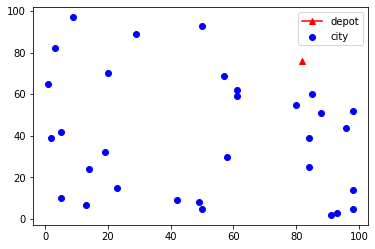

In [5]:
plot(data)

In [6]:
k = 5 #no. of clusters or no. of vehicles
n = 31 #no. of cities excluding depot
capacity = 100 #capacity of each cluster

In [7]:
#initial k centroids from first k largest(based on demand) cities
sorted_data = data.sort_values(by='demand', ascending=False)
s_data = sorted_data[0:int(k)]
s_data.reset_index(drop=True, inplace=True)
centroids = []
for i in range(k):
  centroids.append(list((s_data['xcodinate'][i],s_data['ycordinate'][i])))
centroids_index = list(sorted_data[0:5].index)

In [8]:
s_data

,xcodinate,ycordinate,demand
0,61,62,24
1,9,97,24
2,93,3,24
3,1,65,22
4,50,5,21


In [9]:
centroids

[[61, 62], [9, 97], [93, 3], [1, 65], [50, 5]]

In [10]:
def distance_calculator(data,centroids,centroids_index):
  new_data = data.drop(index = centroids_index)
  new_data = new_data.drop(index = [0]) #dropping the depot
  saved_index = [x for x in range(1,len(data)) if x not in centroids_index]
  new_data.reset_index(drop = True, inplace = True)
  distance_matrix = np.zeros(shape = (len(new_data),len(centroids_index)))

  for i in range(len(new_data)):
    for j in range(len(centroids_index)):
      distance_matrix[i,j] = np.round(np.sqrt((new_data['xcodinate'][i]-centroids[j][0])**2 + (new_data['ycordinate'][i]-centroids[j][1])**2 ),1)
  return distance_matrix, saved_index, new_data

In [11]:
#calculating new centroids
def calculate_centroid_coordinates(data,centroids_index):
  return list((np.average(data['xcodinate'][centroids_index]),np.average(data['ycordinate'][centroids_index])))

In [12]:
def cluster(data,n,k,capacity,centroids,centroids_index):
  #give k clusters. A city will always be in a cluster

  ##initial k centroids from first k largest(based on demand) cities
  #sorted_data = data.sort_values(by='demand', ascending=False)
  #s_data = sorted_data[0:int(k)]
  #s_data.reset_index(drop=True, inplace=True)
  #centroids = []
  #for i in range(k):
    #centroids.append(list((s_data['xcodinate'],s_data['ycordinate'])))
  #centroids_index = list(sorted_data[0:5].index)
  
  dist_matx, saved_index, new_data = distance_calculator(data,centroids,centroids_index)
  df = pd.DataFrame(dist_matx, index = saved_index, columns = centroids_index)

  #now we fave a df with k columns and n-k rows and each value in ith row and jth column is distance between ith city and jth centriod
  priority_df = df.copy()
  for i in saved_index:
    for j in centroids_index:
      priority_df[j][i] = np.round(priority_df[j][i]/data['demand'][i],1)

  lol = []  #list of list contains k list each list contain index for cities in one cluster
  df2 = priority_df.copy()
  for i in centroids_index:
    df2 = df2.sort_values(by = i, ascending=False)
    sum = data['demand'][i]
    l = []
    for j in list(df2.index) :
        sum += data['demand'][j]
        if sum > capacity :
          break
        l.append(j) 
    lol.append(l)
    df2.drop(index = l, inplace=True)
  
  for l in lol :
    if len(l)==0:
      k = lol.index(l)
      if k == 0:
        return lol
  lol = lol[:k]
             
  return lol

In [13]:
start= timeit.default_timer()
lol = cluster(data,n,k,capacity,centroids,centroids_index)
stop = timeit.default_timer()
time1 = -start + stop

In [14]:
lol

[[18, 29, 28, 22, 26, 8, 3, 10, 31, 23, 5, 11],
 [14, 21, 6, 17, 13, 30],
 [20, 9, 4, 27],
 [7, 1, 16, 12]]

In [15]:
for l in lol :
  print(calculate_centroid_coordinates(data,l))

[32.25, 36.75]
[79.5, 31.666666666666668]
[30.5, 52.0]
[91.5, 46.5]


In [16]:
start= timeit.default_timer()
centroid_coordinate = []
for l in lol :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
stop= timeit.default_timer()
time2 = -start + stop

In [17]:
centroid_coordinate

[[32.25, 36.75], [79.5, 31.666666666666668], [30.5, 52.0], [91.5, 46.5]]

In [18]:
def new_distance_calculator(data,lol):
  new_data = data
  new_data = new_data.drop(index = [0]) #dropping the depot
  #new_data.reset_index(drop = True, inplace = True)
  saved_index = list(new_data.index)
  centroid_coordinate = []
  for l in lol :
    centroid_coordinate.append(calculate_centroid_coordinates(data,l))
  
  distance_matrix = np.zeros(shape = (len(new_data),len(centroid_coordinate)))

  for i in range(1,len(new_data)):
    for j in range(len(centroid_coordinate)):
      distance_matrix[i,j] = np.round(np.sqrt((new_data['xcodinate'][i]-centroid_coordinate[j][0])**2 + (new_data['ycordinate'][i]-centroid_coordinate[j][1])**2 ),1)
  return distance_matrix, saved_index

In [19]:
dmatrix, saved_index = new_distance_calculator(data,lol)

In [20]:
def cluster_again(data,lol,dmatrix,saved_index):

  df = pd.DataFrame(dmatrix, index = saved_index,columns=range(len(centroid_coordinate)))
  #data = data.drop(index = [0])
  priority_df = df.copy()
  for i in saved_index:
    for j in range(len(centroid_coordinate)):
      priority_df[j][i] = np.round(priority_df[j][i]/data['demand'][i],1)

  
  lol = []  #list of list contains k list each list contain index for cities in one cluster
  df2 = priority_df.copy()
  new_data = data
  new_data = new_data.drop(index = [0])
  for i in range(len(centroid_coordinate)):
    df2 = df2.sort_values(by = i, ascending=False)
    sum = 0
    l = []
    for j in list(df2.index) :
        sum += new_data['demand'][j]
        if sum > capacity :
          break
        l.append(j) 
    lol.append(l)
    df2.drop(index = l, inplace=True)
  
  for l in lol :
    if len(l)==0:
      k = lol.index(l)
      print(k)
  #lol = lol[:k]
             
  return lol

In [21]:
def new_plot(data,lol, centroid_coordinate):
  color_list = ['g','b','y','r','c','m','k']
  #m_list = ["x","o","v"]
  plt.figure(figsize=(20,10))
  plt.scatter(data['xcodinate'][0],data['ycordinate'][0],marker = "^",s = 500,color = 'pink' ,label = 'depot')
  for l in lol:
    k = lol.index(l)
    plt.scatter(data['xcodinate'][l], data['ycordinate'][l], marker = "o",s=100 ,color = color_list[lol.index(l)], label = 'city in cluster'+str(k))
    #plt.plot(data['xcodinate'][l], data['ycordinate'][l], marker = "o", color = color_list[lol.index(l)], label = 'city')
  for i in range(len(centroid_coordinate)):
    plt.scatter(centroid_coordinate[i][0],centroid_coordinate[i][1], marker = '^', s = 500,color = color_list[i], label ='cluster center'+str(i) )
  plt.legend()
  plt.xlabel('x axis')
  plt.ylabel('y axis')
  plt.show()

FIRST ITERATION------
cluster centriods are
[[46.06666666666667, 42.86666666666667], [53.333333333333336, 36.833333333333336], [59.0, 24.4], [41.0, 56.75]]
clustors are
[[18, 26, 14, 22, 29, 28, 20, 8, 31, 3, 5, 21, 6, 13, 10], [23, 11, 30, 16, 9, 12], [2, 17, 4, 27, 7], [19, 24, 15, 25]]


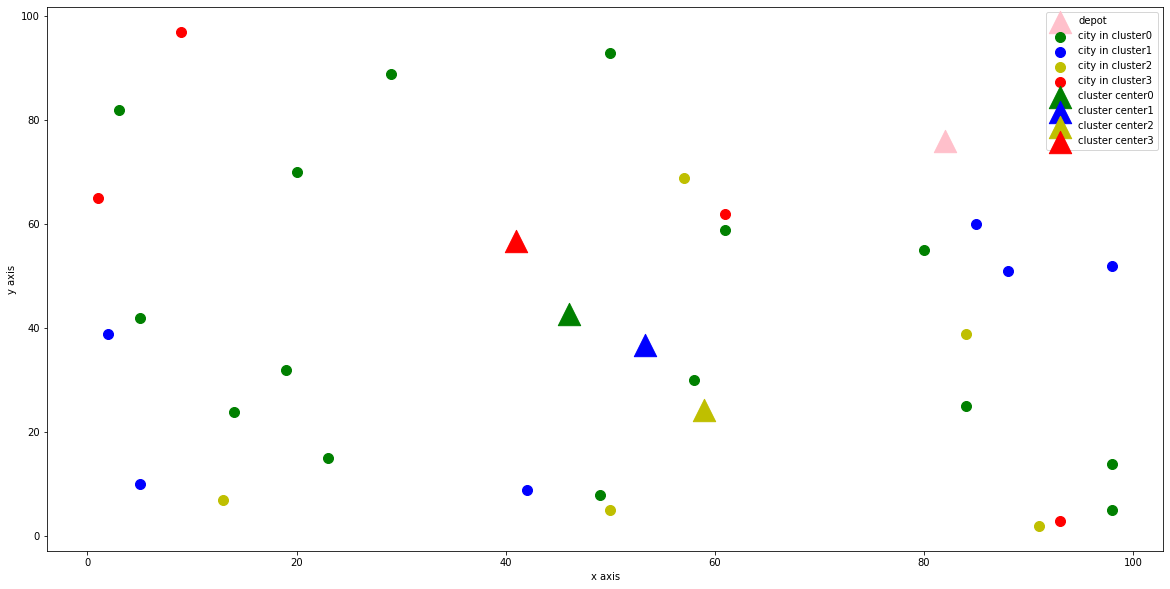

In [22]:
dmatrix, saved_index = new_distance_calculator(data,lol)
lol2 = cluster_again(data,lol,dmatrix,saved_index)
centroid_coordinate = []
for l in lol2 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('FIRST ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol2)
new_plot(data,lol2,centroid_coordinate)

SECOND ITERATION------
cluster centriods are
[[39.733333333333334, 40.46666666666667], [69.16666666666667, 42.833333333333336], [72.75, 19.75], [39.75, 43.25]]
clustors are
[[18, 26, 29, 22, 14, 20, 28, 5, 8, 3, 10, 23, 31, 11, 21], [6, 30, 16, 13, 12, 9], [17, 2, 27, 19], [4, 24, 7, 15]]


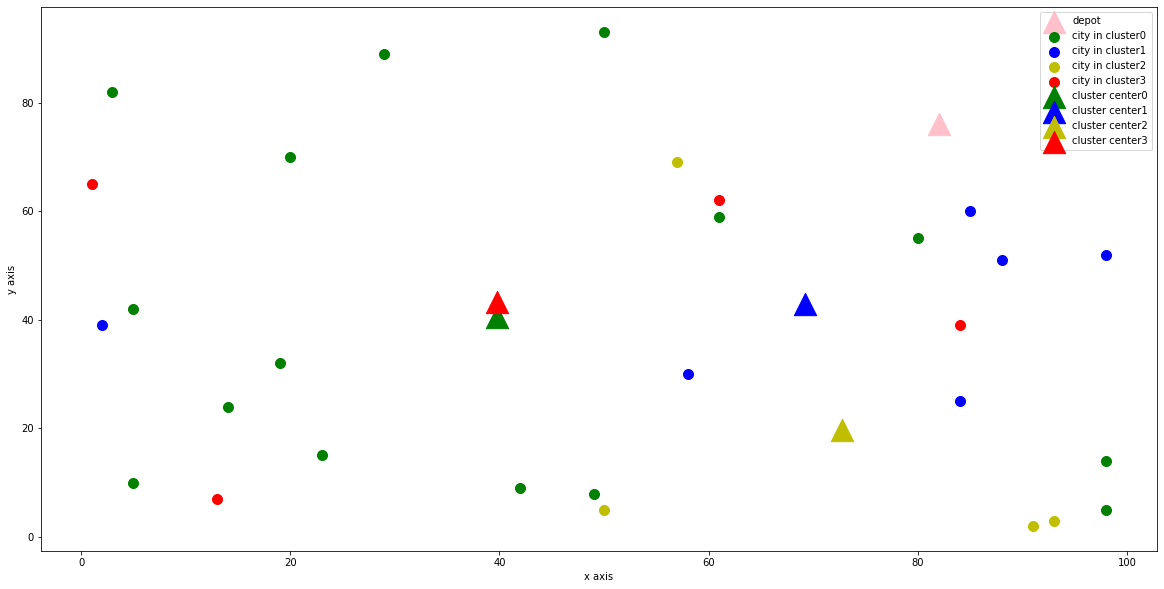

In [23]:
dmatrix, saved_index = new_distance_calculator(data,lol2)
lol3 = cluster_again(data,lol2,dmatrix,saved_index)
centroid_coordinate = []
for l in lol3 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('SECOND ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol3)
new_plot(data,lol3,centroid_coordinate)

THIRD ITERATION------
cluster centriods are
[[43.266666666666666, 41.8], [55.6, 42.4], [67.25, 23.75], [53.0, 36.4]]
clustors are
[[18, 26, 22, 14, 29, 28, 20, 8, 3, 5, 31, 10, 21, 23, 6], [11, 30, 16, 9, 12], [13, 19, 15, 17], [2, 27, 4, 24, 7]]


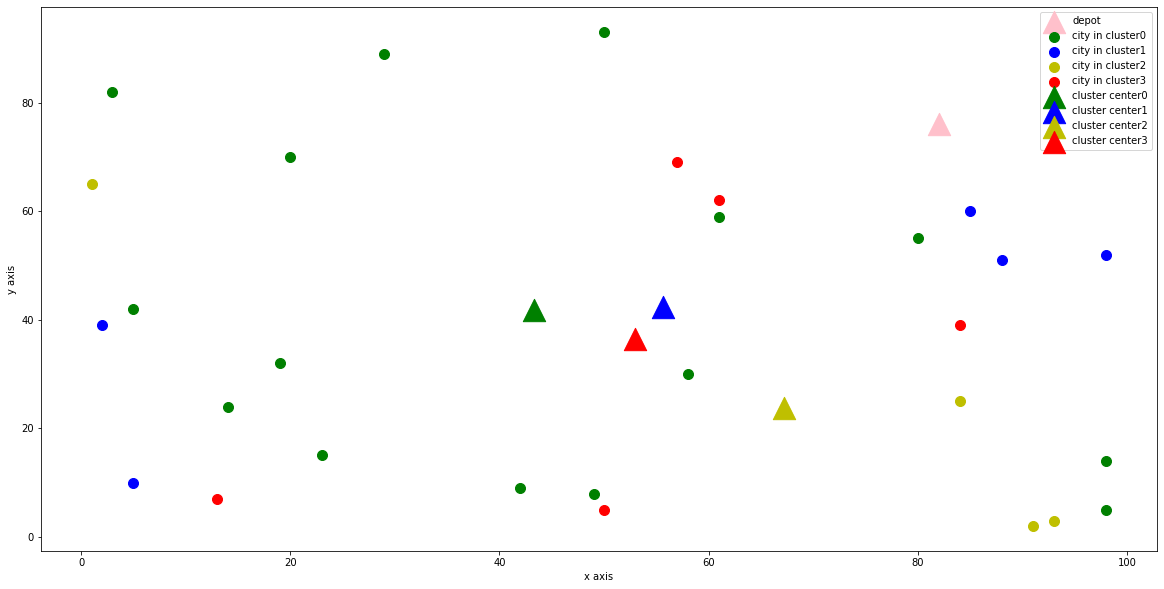

In [24]:
dmatrix, saved_index = new_distance_calculator(data,lol3)
lol4 = cluster_again(data,lol3,dmatrix,saved_index)
centroid_coordinate = []
for l in lol4 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('THIRD ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol4)
new_plot(data,lol4,centroid_coordinate)

FOURTH ITERATION------
cluster centriods are
[[43.266666666666666, 41.8], [60.333333333333336, 39.5], [72.75, 19.75], [21.0, 57.75]]
clustors are
[[18, 26, 29, 22, 14, 20, 28, 8, 5, 3, 10, 31, 23, 21, 6], [11, 16, 30, 12, 9, 13], [19, 17, 2, 27], [4, 24, 15, 25]]


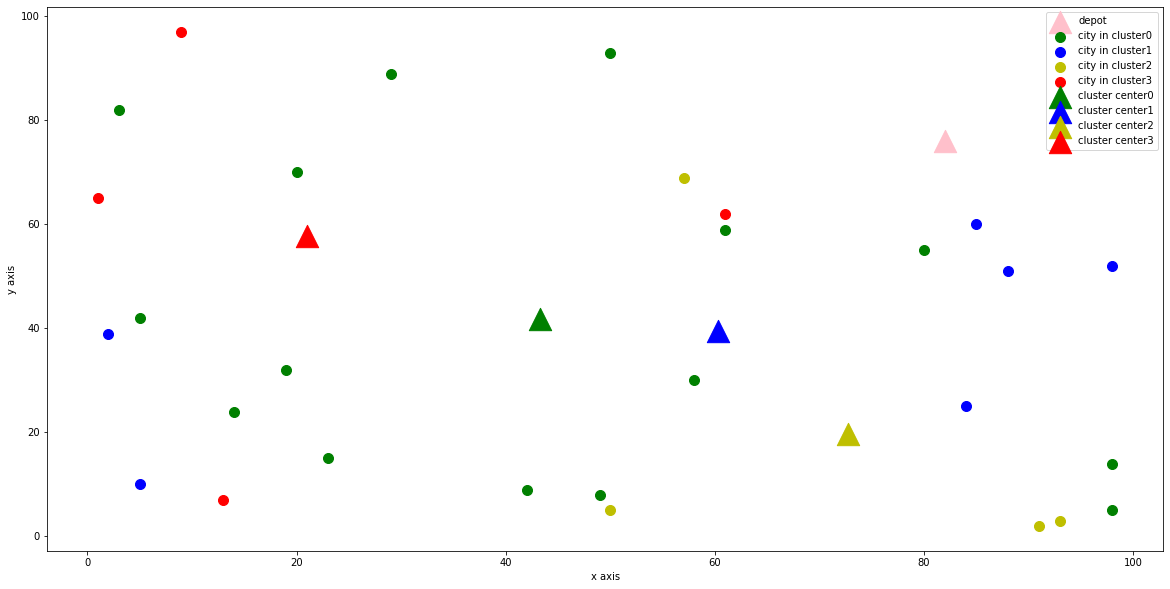

In [25]:
dmatrix, saved_index = new_distance_calculator(data,lol4)
lol5 = cluster_again(data,lol4,dmatrix,saved_index)
centroid_coordinate = []
for l in lol5 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('FOURTH ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol5)
new_plot(data,lol5,centroid_coordinate)

5 ITERATION------
cluster centriods are
[[43.266666666666666, 41.8], [60.333333333333336, 39.5], [60.5, 34.75], [52.0, 28.25]]
clustors are
[[18, 26, 29, 22, 14, 20, 28, 8, 5, 3, 10, 31, 23, 21, 6], [11, 16, 30, 12, 9, 13], [19, 17, 2, 27], [4, 24, 15, 25]]


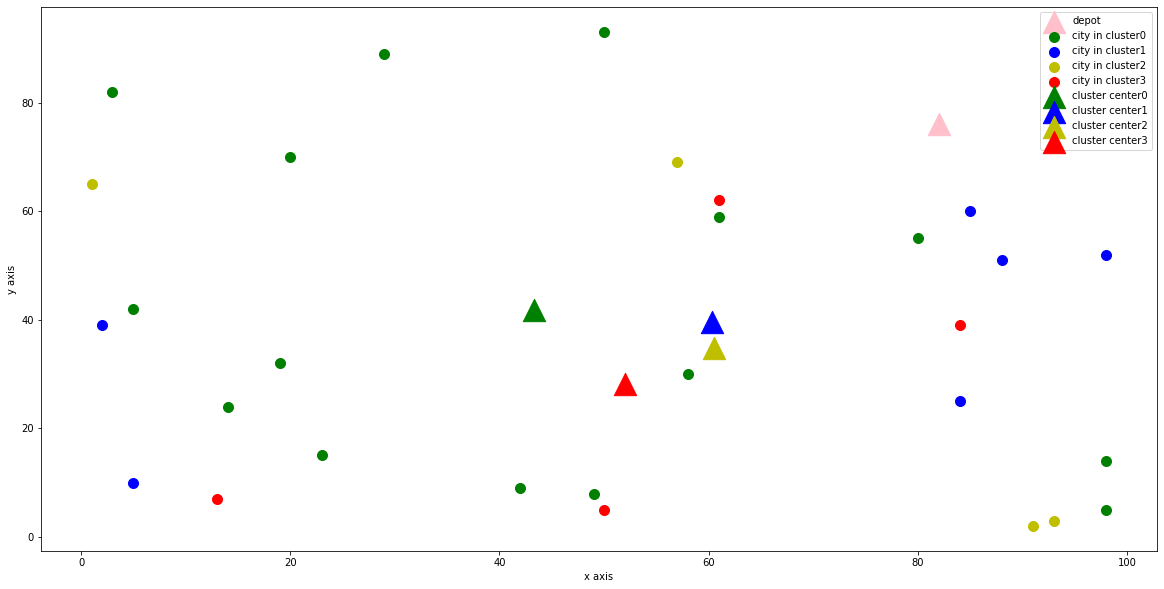

In [26]:
dmatrix, saved_index = new_distance_calculator(data,lol5)
lol6 = cluster_again(data,lol5,dmatrix,saved_index)
centroid_coordinate = []
for l in lol6 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('5 ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol5)
new_plot(data,lol6,centroid_coordinate)

6 ITERATION------
cluster centriods are
[[43.266666666666666, 41.8], [60.333333333333336, 39.5], [61.75, 4.25], [32.0, 73.25]]
clustors are
[[18, 26, 29, 22, 14, 20, 28, 8, 5, 3, 10, 31, 23, 21, 6], [11, 16, 30, 9, 12, 13], [19, 2, 17, 4], [27, 15, 25, 24]]


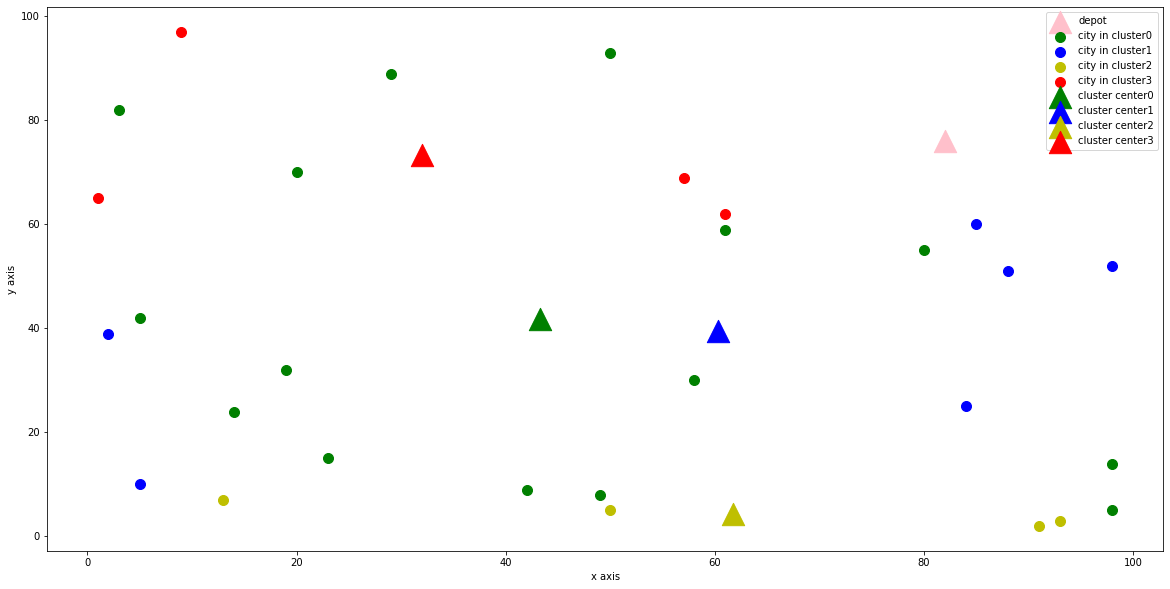

In [27]:
dmatrix, saved_index = new_distance_calculator(data,lol6)
lol7 = cluster_again(data,lol5,dmatrix,saved_index)
centroid_coordinate = []
for l in lol7 :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))
print('6 ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clustors are')
print(lol7)
new_plot(data,lol7,centroid_coordinate)

In [28]:
def converge(lol,itter = 10):
  for i in range(itter):
    dmatrix, saved_index = new_distance_calculator(data,lol)
    lol = cluster_again(data,lol,dmatrix,saved_index)
    centroid_coordinate = []
    for l in lol :
      centroid_coordinate.append(calculate_centroid_coordinates(data,l))

  print(str(itter)+' ITERATION------')
  print('cluster centriods are')
  print(centroid_coordinate)
  print('clusters are')
  print(lol)
  new_plot(data,lol,centroid_coordinate)

In [29]:
lol

[[18, 29, 28, 22, 26, 8, 3, 10, 31, 23, 5, 11],
 [14, 21, 6, 17, 13, 30],
 [20, 9, 4, 27],
 [7, 1, 16, 12]]

10 ITERATION------
cluster centriods are
[[43.266666666666666, 41.8], [60.333333333333336, 39.5], [52.75, 20.75], [41.0, 56.75]]
clusters are
[[18, 26, 29, 22, 14, 20, 28, 8, 5, 3, 10, 31, 23, 21, 6], [11, 16, 30, 9, 12, 13], [2, 17, 27, 4], [19, 15, 25, 24]]


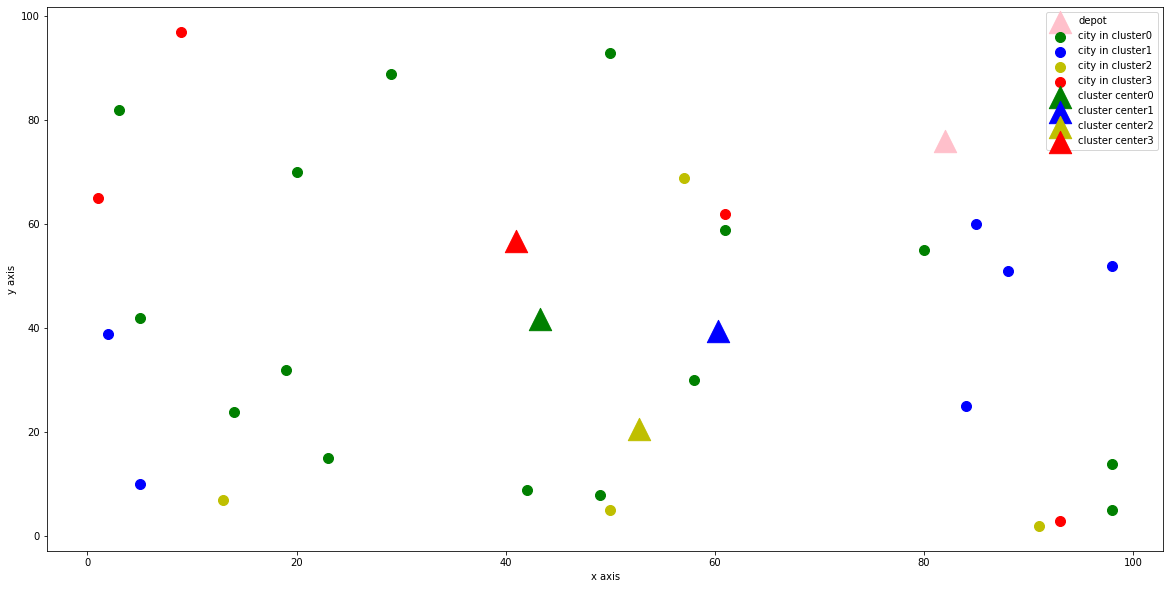

In [30]:
converge(lol,10)

100 ITERATION------
cluster centriods are
[[43.266666666666666, 41.8], [60.333333333333336, 39.5], [52.75, 20.75], [41.0, 56.75]]
clusters are
[[18, 26, 29, 22, 14, 20, 28, 8, 5, 3, 10, 31, 23, 21, 6], [11, 16, 30, 9, 12, 13], [2, 17, 27, 4], [19, 15, 25, 24]]


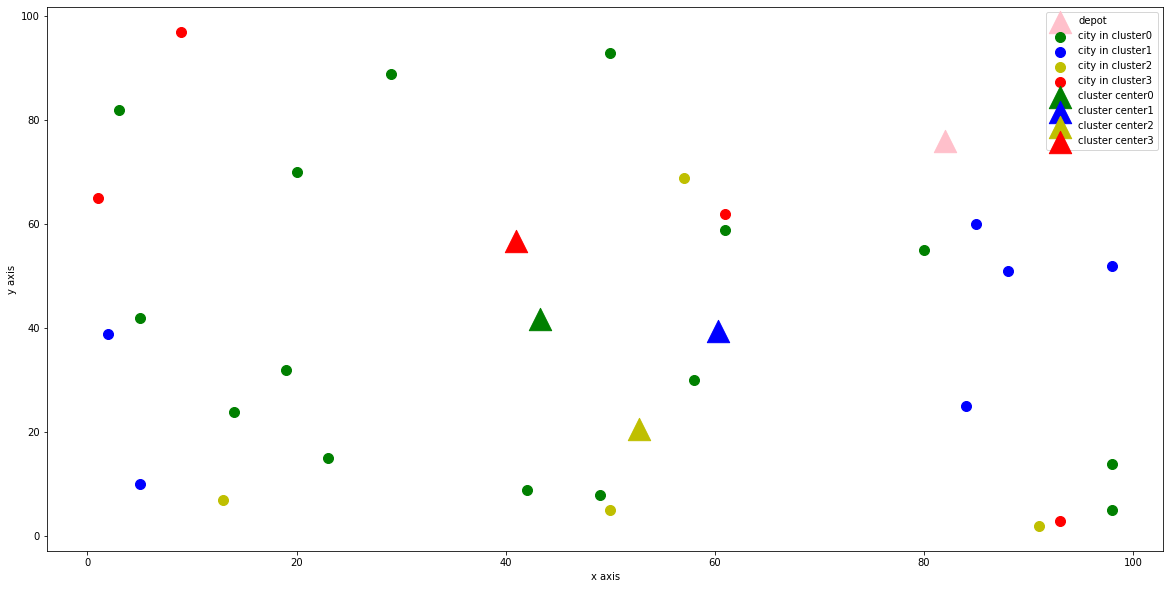

In [31]:
start= timeit.default_timer()
converge(lol,100)
stop= timeit.default_timer()
time3 = -start + stop

In [32]:
def converge_cluster(lol,itter = 10):
  for i in range(itter):
    dmatrix, saved_index = new_distance_calculator(data,lol)
    lol = cluster_again(data,lol,dmatrix,saved_index)
    centroid_coordinate = []
    for l in lol :
      centroid_coordinate.append(calculate_centroid_coordinates(data,l))
  return lol

In [33]:
final_cluster = converge_cluster(lol,10)
final_cluster

[[18, 26, 29, 22, 14, 20, 28, 8, 5, 3, 10, 31, 23, 21, 6],
 [11, 16, 30, 9, 12, 13],
 [2, 17, 27, 4],
 [19, 15, 25, 24]]

In [34]:
tightness_list = []
for clusters in final_cluster:
  demand_sum = 0
  for city in clusters:
    demand_sum += data['demand'][city]
  #print('tightness ratio', demand_sum/capacity)
  tightness_list.append(demand_sum/capacity)
print('tightness ratio for all clusters',tightness_list)
print('average tightness ratio',np.average(tightness_list) )

tightness ratio for all clusters [0.92, 0.99, 0.79, 0.94]
average tightness ratio 0.91


### optimal route for 32 cities
Route #1: 21 31 19 17 13 7 26

Route #2: 12 1 16 30

Route #3: 27 24

Route #4: 29 18 8 9 22 15 10 25 5 20

Route #5: 14 28 11 4 23 3 2 6

Cost 784

[solution here](http://vrp.atd-lab.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.sol)

In [35]:
opt_cluster = list(([21 ,31 ,19 ,17 ,13 ,7 ,26],[12 ,1 ,16 ,30],[27 ,24],[29 ,18, 8, 9 ,22 ,15 ,10, 25, 5 ,20],[14 ,28, 11 ,4 ,23, 3, 2, 6]))

In [36]:
tightness_list = []
for clusters in opt_cluster:
  demand_sum = 0
  for city in clusters:
    demand_sum += data['demand'][city]
  tightness_list.append(demand_sum/capacity)
print('tightness ratio for all clusters',tightness_list)
print('average tightness ratio',np.average(tightness_list) )

tightness ratio for all clusters [0.98, 0.72, 0.44, 0.98, 0.87]
average tightness ratio 0.798


#### Lets use TSP on each cluster to solve the VRP

In [37]:
pip install python-tsp

In [44]:
# lets create a distance calculator function

def dist_matrix(data,cluster):
  #cluster is a list
  #data is dataframe with row index 0 as depot
  cluster.append(0)
  n = len(cluster)
  dis_mat = np.zeros(shape= (n,n))
  for i in range(n):
    for j in range(n):
      if i != j :
        dis_mat[i][j] = np.sqrt((data['xcodinate'][cluster[i]] - data['xcodinate'][cluster[j]])**2 + (data['ycordinate'][cluster[i]] - data['ycordinate'][cluster[j]])**2)
  return dis_mat

In [39]:
from python_tsp.exact import solve_tsp_dynamic_programming

In [45]:
start= timeit.default_timer()
cost1 = []
for cluster_ in final_cluster:
  tour, tour_cost = solve_tsp_dynamic_programming(dist_matrix(data,cluster_))
  cost1.append(tour_cost)
stop= timeit.default_timer()
time4 = -start+stop
#print(cost1)
print('total cost of the VRP with 32 cities',np.sum(cost1))

total cost of the VRP with 32 cities 1198.6191456755967


In [46]:
print('time taken to solve 32 cities VRP with kmeans followed by TSP', time1 + time2 + time3 + time4)

time taken to solve 32 cities VRP with kmeans followed by TSP 16.302474830000392


## overall pipeline to get the tightness ratio

In [47]:
def pipeline(data,k,n,capacity,itter):
  #initial k centroids from first k largest(based on demand) cities
  sorted_data = data.sort_values(by='demand', ascending=False)
  s_data = sorted_data[0:int(k)]
  s_data.reset_index(drop=True, inplace=True)
  centroids = []
  for i in range(k):
    centroids.append(list((s_data['xcodinate'][i],s_data['ycordinate'][i])))
  centroids_index = list(sorted_data[0:k].index)

  lol = cluster(data,n,k,capacity,centroids,centroids_index)

  centroid_coordinate = []
  for l in lol :
    centroid_coordinate.append(calculate_centroid_coordinates(data,l))

  dmatrix, saved_index = new_distance_calculator(data,lol)

  converge(lol,itter)

  final_cluster = converge_cluster(lol,itter)

  tightness_list = []
  for clusters in final_cluster:
    demand_sum = 0
    for city in clusters:
      demand_sum += data['demand'][city]
  #print('tightness ratio', demand_sum/capacity)
    tightness_list.append(demand_sum/capacity)
  print('tightness ratio for all clusters',tightness_list)
  print('average tightness ratio',np.average(tightness_list))

100 ITERATION------
cluster centriods are
[[43.266666666666666, 41.8], [60.333333333333336, 39.5], [52.75, 20.75], [41.0, 56.75]]
clusters are
[[18, 26, 29, 22, 14, 20, 28, 8, 5, 3, 10, 31, 23, 21, 6], [11, 16, 30, 9, 12, 13], [2, 17, 27, 4], [19, 15, 25, 24]]


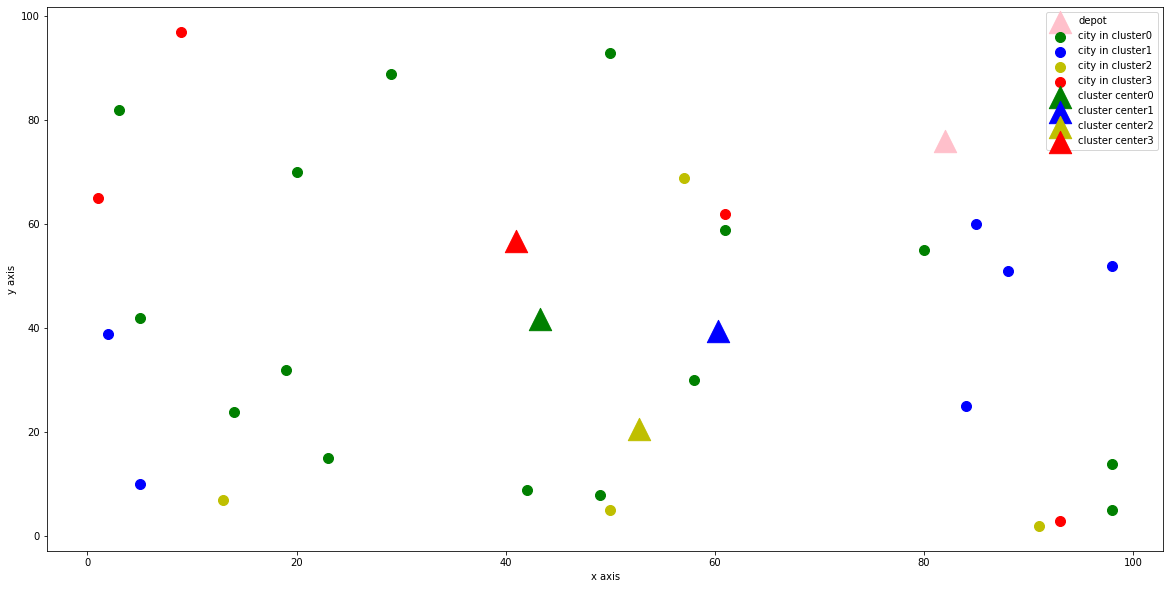

tightness ratio for all clusters [0.92, 0.99, 0.79, 0.94]
average tightness ratio 0.91


In [48]:
pipeline(data,k=5,n=31,capacity=100,itter=100)

## new vrp instance with 45 cities

In [49]:
data45 = pd.read_excel('/content/vrp_instance_n45_k7(1).xlsx')

In [50]:
data = data45

In [51]:
sorted_data = data.sort_values(by='demand', ascending=False)
s_data = sorted_data[0:int(k)]
s_data.reset_index(drop=True, inplace=True)
centroids = []
for i in range(k):
  centroids.append(list((s_data['xcodinate'][i],s_data['ycordinate'][i])))
centroids_index = list(sorted_data[0:k].index)

In [52]:
centroids_index

[22, 33, 17, 44, 4]

In [53]:
centroids

[[63, 25], [41, 27], [89, 43], [35, 35], [39, 75]]

In [54]:
n = 44
k = 7

In [55]:
lol = cluster(data,n,k,capacity,centroids,centroids_index)

In [56]:
centroid_coordinate = []
for l in lol :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))

In [57]:
dmatrix, saved_index = new_distance_calculator(data,lol)

100 ITERATION------
cluster centriods are
[[60.23076923076923, 58.84615384615385], [67.85714285714286, 51.857142857142854], [43.8, 47.4], [51.8, 32.2], [39.5, 46.0]]
clusters are
[[2, 8, 38, 21, 41, 7, 13, 6, 42, 16, 20, 31, 28], [25, 37, 32, 14, 5, 40, 12], [39, 26, 30, 44, 11], [9, 3, 19, 36, 17], [29, 4, 35, 27]]


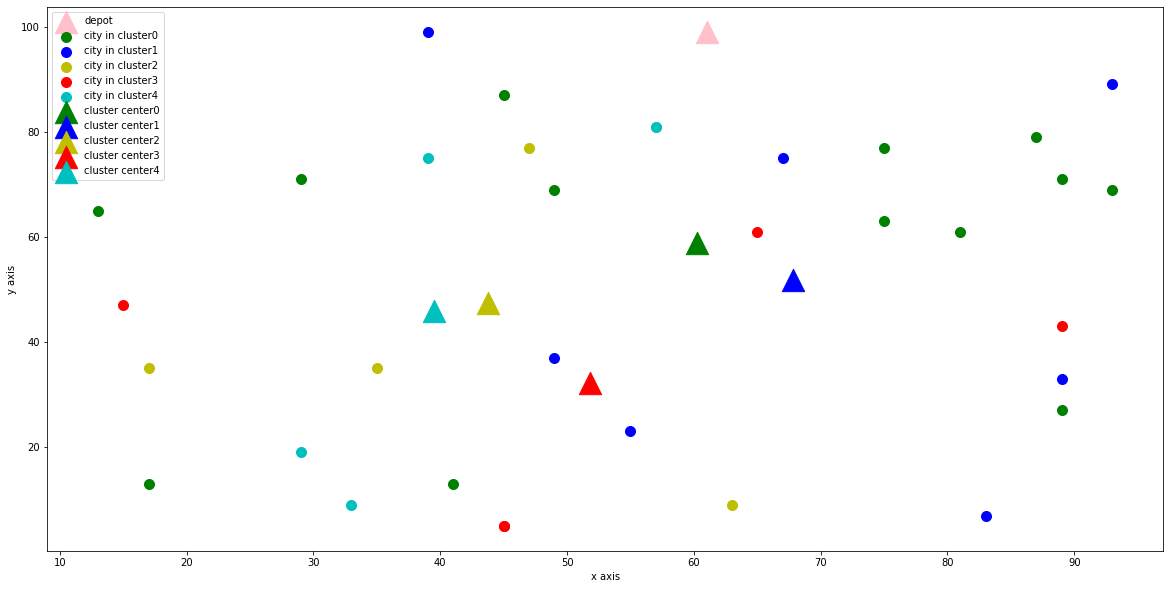

In [58]:
converge(lol,itter=100)

In [59]:
final_cluster = converge_cluster(lol,itter=100)

tightness_list = []
for clusters in final_cluster:
  demand_sum = 0
  for city in clusters:
    demand_sum += data['demand'][city]
#print('tightness ratio', demand_sum/capacity)
  tightness_list.append(demand_sum/capacity)
print('tightness ratio for all clusters',tightness_list)
print('average tightness ratio',np.average(tightness_list))

tightness ratio for all clusters [0.87, 0.85, 0.83, 0.92, 0.84]
average tightness ratio 0.8619999999999999


##optimal route for 45 city
Route #1: 8 42 1 37 30 5 22 

Route #2: 13 38 17 23 25 15 10 

Route #3: 18 7 16 20 40 

Route #4: 39 21 24 44 14 9 32

Route #5: 33 29 19 36 31 

Route #6: 27 41 43 11 3 28 6 2 

Route #7: 12 4 26 34 35 

Cost 1146

[solution here](http://vrp.atd-lab.inf.puc-rio.br/media/com_vrp/instances/A/A-n45-k7.sol)

In [60]:
opt_cluster = list(([8 ,42, 1, 37 ,30, 5, 22],[13, 38, 17, 23 ,25, 15 ,10],[18, 7 ,16, 20, 40],[39, 21, 24 ,44 ,14, 9 ,32],
                    [33, 29 ,19 ,36, 31],[27 ,41, 43, 11 ,3 ,28, 6, 2],[12, 4 ,26, 34 ,35]))

In [61]:
tightness_list = []
for clusters in opt_cluster:
  demand_sum = 0
  for city in clusters:
    demand_sum += data['demand'][city]
  tightness_list.append(demand_sum/capacity)
print('tightness ratio for all clusters',tightness_list)
print('average tightness ratio',np.average(tightness_list))

tightness ratio for all clusters [0.99, 0.99, 0.56, 0.93, 0.98, 0.96, 0.93]
average tightness ratio 0.9057142857142857


In [62]:
cost2 = []
for cluster_ in final_cluster:
  tour, tour_cost = solve_tsp_dynamic_programming(dist_matrix(data,cluster_))
  cost2.append(tour_cost)
#print(cost2)
print('total cost of the VRP with 45 cities',np.sum(cost2))

total cost of the VRP with 45 cities 1243.3976082302045


## new vrp instance with 60 cities


In [63]:
data60 = pd.read_excel('/content/vrp_instance_n60_k9.xlsx')

In [64]:
data = data60
n = 59
k = 9

In [65]:
sorted_data = data.sort_values(by='demand', ascending=False)
s_data = sorted_data[0:int(k)]
s_data.reset_index(drop=True, inplace=True)
centroids = []
for i in range(k):
  centroids.append(list((s_data['xcodinate'][i],s_data['ycordinate'][i])))
centroids_index = list(sorted_data[0:k].index)

In [66]:
lol = cluster(data,n,k,capacity,centroids,centroids_index)

In [67]:
centroid_coordinate = []
for l in lol :
  centroid_coordinate.append(calculate_centroid_coordinates(data,l))

In [68]:
dmatrix, saved_index = new_distance_calculator(data,lol)

In [69]:
itter = 100
for i in range(itter):
  dmatrix, saved_index = new_distance_calculator(data,lol)
  lol = cluster_again(data,lol,dmatrix,saved_index)
  centroid_coordinate = []
  for l in lol :
    centroid_coordinate.append(calculate_centroid_coordinates(data,l))

print(str(itter)+' ITERATION------')
print('cluster centriods are')
print(centroid_coordinate)
print('clusters are')
print(lol)

100 ITERATION------
cluster centriods are
[[42.1, 55.8], [53.57142857142857, 64.71428571428571], [17.285714285714285, 51.285714285714285], [63.333333333333336, 42.333333333333336], [54.5, 62.5], [54.5, 87.5], [59.5, 61.5], [57.666666666666664, 29.666666666666668], [68.33333333333333, 38.333333333333336]]
clusters are
[[46, 20, 18, 37, 27, 49, 32, 2, 19, 21, 50, 10, 33, 58, 15, 30, 31, 55, 5, 34], [9, 52, 54, 38, 14, 3, 13], [16, 36, 28, 44, 6, 40, 4], [35, 47, 12, 42, 26, 22], [11, 43, 29, 23], [57, 25, 7, 41], [17, 39, 8, 53], [56, 24, 45], [51, 59, 48]]


In [70]:
final_cluster = converge_cluster(lol,itter=100)

tightness_list = []
for clusters in final_cluster:
  demand_sum = 0
  for city in clusters:
    demand_sum += data['demand'][city]
#print('tightness ratio', demand_sum/capacity)
  tightness_list.append(demand_sum/capacity)
print('tightness ratio for all clusters',tightness_list)
print('average tightness ratio',np.average(tightness_list))

tightness ratio for all clusters [0.99, 0.93, 0.94, 0.99, 0.8, 0.82, 0.87, 0.66, 0.65]
average tightness ratio 0.8500000000000001


## optimal solution for 60 city vrp

Route #1: 2 1 48 22 36 31  

Route #2: 4 21 53 30 49 44 28 6

Route #3: 7 29 13 8 15 55 35

Route #4: 10 54 5 45 42 

Route #5: 14 47 23 58 24 34 

Route #6: 16 20 3 11 40 46 25 

Route #7: 18 52 59 38 33 41 

Route #8: 19 27 57 37 17 26 39

Route #9: 32 9 51 12 56 43 50

Cost 1354

[solution here](http://vrp.atd-lab.inf.puc-rio.br/media/com_vrp/instances/A/A-n60-k9.sol)

In [71]:
opt_cluster = list(([2 ,1 ,48 ,22, 36, 31],[4 ,21, 53 ,30 ,49, 44, 28, 6],[7, 29, 13, 8 ,15, 55, 35],
                    [10 ,54,5, 45, 42],[14 ,47 ,23 ,58 ,24, 34],[16, 20, 3 ,11, 40, 46, 25],
                    [18 ,52, 59 ,38 ,33, 41],[19, 27, 57, 37, 17, 26,39],[32, 9 ,51 ,12, 56, 43, 50]))

In [72]:
tightness_list = []
for clusters in opt_cluster:
  demand_sum = 0
  for city in clusters:
    demand_sum += data['demand'][city]
  tightness_list.append(demand_sum/capacity)
print('tightness ratio for all clusters',tightness_list)
print('average tightness ratio',np.average(tightness_list))

tightness ratio for all clusters [1.0, 1.0, 1.0, 0.94, 0.95, 0.68, 0.84, 0.91, 0.97]
average tightness ratio 0.9211111111111112


In [73]:
cost3 = []
for cluster_ in final_cluster:
  tour, tour_cost = solve_tsp_dynamic_programming(dist_matrix(data,cluster_))
  cost3.append(tour_cost)
#print(cost3)
print('total cost of the VRP with 60 cities',np.sum(cost3))

total cost of the VRP with 60 cities 2174.5246635878316


# final results

**for 32 cities, k=5 vrp instance --------->**

no. of itterations to calculate = 100

no. of cluster generated = 4

average tightness obtained = 0.91

no. of routes in optimum solution = 5

average tightness for optimum solution = 0.789


**for 45 cities, k=7 vrp instance --------->**

no. of itterations to calculate = 100

no. of cluster generated = 5

average tightness obtained = 0.862

no. of routes in optimum solution = 7

average tightness for optimum solution = 0.906

**for 60 cities, k=9 vrp instance --------->**

no. of itterations to calculate = 100

no. of cluster generated = 9

average tightness obtained = 0.850

no. of routes in optimum solution = 9

average tightness for optimum solution = 0.921

optimal cost for 32 cities VRP = 784

cost for 32 cities VPR using K-means followed by solving TSP on each cluster =  1198.62

optimal cost for 45 cities VRP = 1146 

cost for 45 cities VPR using K-means followed by solving TSP on each cluster = 1243.4

optimal cost for 60 cities VRP = 1354

cost for 60 cities VPR using K-means followed by solving TSP on each cluster = 2174.52

In [74]:
opt_cost1 = 784
opt_cost2 = 1146
opt_cost3 = 1354

In [75]:
opt_cost = [opt_cost1, opt_cost2, opt_cost3]

In [76]:
achieved_cost = [np.sum(cost1), np.sum(cost2),np.sum(cost3)]

In [77]:
achieved_cost

[1198.6191456755967, 1243.3976082302045, 2174.5246635878316]

In [79]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [81]:
MAPE(np.array(opt_cost),np.array(achieved_cost))

40.66135427161981

In [82]:
print('closeness to optimum', 100 - MAPE(np.array(opt_cost),np.array(achieved_cost)))

closeness to optimum 59.33864572838019
